In [102]:
from PIL import Image
img = Image.open('shrek_krupnym_planom.png')
# img.show()
# print(img.mode)

In [103]:
import numpy as np
npimg = np.array(img)
npimg.shape

(844, 1400, 3)

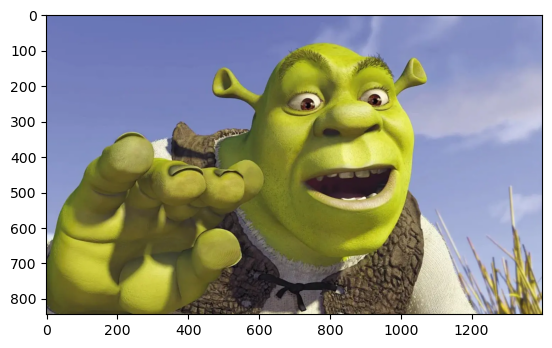

In [104]:
import matplotlib.pyplot as plt
plt.imshow(npimg)

In [111]:
print(npimg.dtype, npimg.shape)

uint8 (844, 1400, 3)


```python
M_X = np.array(
    [[-1, 0, 1], 
     [-2, 0, 2], 
     [-1, 0, 1]]
)

M_Y = np.array(
    [[-1, -2, -1], 
     [0, 0, 0], 
     [1, 2, 1]]
)
```

In [133]:
from tqdm.notebook import tqdm

def apply_sobel(image: np.ndarray) -> np.ndarray:
    height, width, channels = image.shape
    assert channels == 3
    # height, width = image.shape
    out_image = np.zeros((height, width, channels), dtype=np.uint8)
    gray_weights = [0.299, 0.587, 0.114]

    for i in tqdm(range(height)):
        for j in range(width):
            i_0 = max(min(i - 1, height - 1), 0)
            i_1 = i
            i_2 = max(min(i + 1, height - 1), 0)
            j_0 = max(min(j - 1, width - 1), 0)
            j_1 = j
            j_2 = max(min(j + 1, width - 1), 0)

            img_00 = sum(image[i_0, j_0] * gray_weights)
            img_01 = sum(image[i_0, j_1] * gray_weights)
            img_02 = sum(image[i_0, j_2] * gray_weights)
            img_10 = sum(image[i_1, j_0] * gray_weights)
            img_12 = sum(image[i_1, j_2] * gray_weights)
            img_20 = sum(image[i_2, j_0] * gray_weights)
            img_21 = sum(image[i_2, j_1] * gray_weights)
            img_22 = sum(image[i_2, j_2] * gray_weights)
            # img_00 = image[i_0, j_0]
            # img_01 = image[i_0, j_1]
            # img_02 = image[i_0, j_2]
            # img_10 = image[i_1, j_0]
            # img_12 = image[i_1, j_2]
            # img_20 = image[i_2, j_0]
            # img_21 = image[i_2, j_1]
            # img_22 = image[i_2, j_2]
            # print(f"{'-' * 10}")
            # print(f"{i=}, {j=}")
            # print(np.array([[img_00, img_01, img_02], [img_10, 0, img_12], [img_20, img_21, img_22]]))            

            gx = sum((
                -1 * img_00, -2 * img_10, -1 * img_20,
                 1 * img_02,  2 * img_12,  1 * img_22,
            ))

            gy = sum((
                -1 * img_00, -2 * img_01, -1 * img_02,
                 1 * img_20,  2 * img_21,  1 * img_22,
            ))
            
            grad_norm = (gx**2 + gy**2) ** 0.5
            grad_int = max(min(int(grad_norm), 255), 0)
            
            for ch in range(channels):
                out_image[i, j, ch] = grad_int 
    
    return out_image

In [107]:
out_image = apply_sobel(npimg) #apply_conv(npimg)

  0%|          | 0/844 [00:00<?, ?it/s]

(844, 1400, 3)


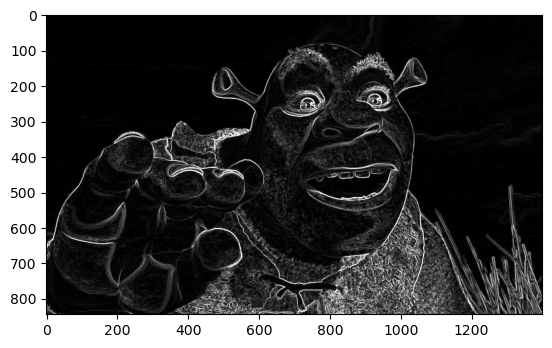

In [166]:
print(out_image.shape)
plt.imshow(out_image[:, :, 0], cmap="grey")
plt.show()

In [198]:
from PIL import Image
import struct
import ctypes


def encode_image(png_filename: str, bin_filename: str="in.data"):
    image = Image.open(png_filename)
    (w, h) = image.size[0:2]
    pix = image.load()
    buff = ctypes.create_string_buffer(4 * w * h)
    offset = 0
    for j in range(h):
        for i in range(w):
            r = bytes((pix[i, j][0],))
            g = bytes((pix[i, j][1],))
            b = bytes((pix[i, j][2],))
            a = bytes((255,))
            struct.pack_into('cccc', buff, offset, r, g, b, a)
            offset += 4
    
    out = open(bin_filename, 'wb')
    out.write(struct.pack('ii', w, h))
    out.write(buff.raw)
    out.close()


def decode_image(png_filename: str, bin_filename: str='out.data') -> None:
    fin = open(bin_filename, 'rb')
    (w, h) = struct.unpack('ii', fin.read(8))
    buff = ctypes.create_string_buffer(4 * w * h)
    fin.readinto(buff)
    fin.close()
    img = Image.new('RGBA', (w, h))
    pix = img.load()
    offset = 0
    for j in range(h):
        for i in range(w):
            (r, g, b, a) = struct.unpack_from('cccc', buff, offset)
            # print(r, g, b, a)
            pix[i, j] = (ord(r), ord(g), ord(b), ord(a))
            offset += 4
    img.save(png_filename)

In [123]:
encode_image(png_filename="shrek_krupnym_planom.png")

In [ ]:
# !nvcc lab.cu -o lab.exe
# !lab.exe

In [236]:
decode_image(png_filename="shrek_krupnym_planom_cuda_result__.png", bin_filename="out_sobel_fix.data")

CUDA image


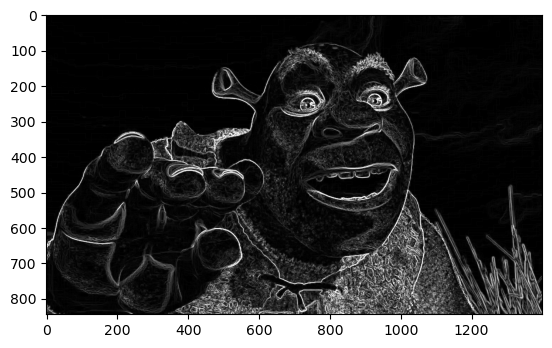

In [237]:
cuda_out_image = np.array(Image.open("shrek_krupnym_planom_cuda_result__.png"))
print("CUDA image")
plt.imshow(cuda_out_image[:, :, 0], cmap="gray")
plt.show()

In [238]:
print(out_image.shape)
print(cuda_out_image.shape)

(844, 1400, 3)
(844, 1400, 4)


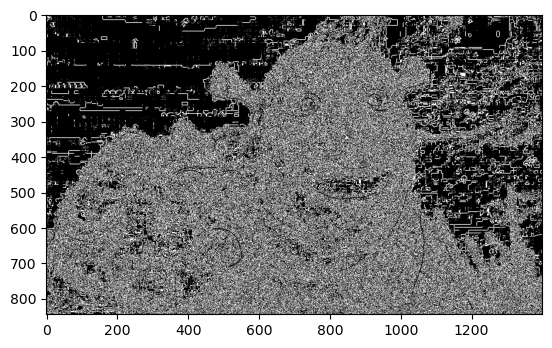

In [239]:
plt.imshow(out_image[:, :, 0] - cuda_out_image[:, :, 0], cmap="gray")

In [240]:
np.abs(cuda_out_image[:, :, 0] - out_image[:, :, 0]).mean()

0.3464209546377793

In [245]:
print(np.abs(cuda_out_image[:, :, 0] - out_image[:, :, 0]).max())
print(np.abs(cuda_out_image[:, :, 0] - out_image[:, :, 0]).min())

1
0


In [243]:
np.allclose(out_image[:, :, 0], cuda_out_image[:, :, 0], rtol=1)

True

In [194]:
# np.allclose(out_image[:, :, 0], out_image[:, :, 1], rtol=1e-9)
np.allclose(cuda_out_image[:, :, 0], cuda_out_image[:, :, 1], rtol=1e-9)

True

In [ ]:
def encode_example(png_filename: str="example.bin"):
    input_image = np.array([
        ["01020300", "04050600", "07080900"],
        ["09080700", "06050400", "03020100"],
        ["00000000", "14141400", "00000000"]
    ])
    heigth, width = 3, 3

    decode_image = np.zeros((3, 3))

    rgb = lambda x: [int(x[:2], 16), int(x[2:4], 16), int(x[4:6], 16)]
    
    image = Image.open(png_filename)
    (w, h) = image.size[0:2]
    pix = image.load()
    buff = ctypes.create_string_buffer(4 * w * h)
    offset = 0
    for j in range(h):
        for i in range(w):
            r = bytes((pix[i, j][0],))
            g = bytes((pix[i, j][1],))
            b = bytes((pix[i, j][2],))
            a = bytes((255,))
            struct.pack_into('cccc', buff, offset, r, g, b, a)
            offset += 4
    
    out = open(bin_filename, 'wb')
    out.write(struct.pack('ii', w, h))
    out.write(buff.raw)
    out.close()

# debug test example

**тут использовал uint_8, но в лекции используется uchar4 для ускорения доступа к памяти**

In [ ]:
# INPUT:
# 03000000 03000000
# 01020300 04050600 07080900
# 09080700 06050400 03020100
# 00000000 14141400 00000000

# OUTPUT:
# 03000000 03000000
# 14141400 0C0C0C00 11111100
# 13131300 15151500 18181800
# 39393900 14141400 3F3F3F00

In [77]:
input_image = np.array([
    ["01020300", "04050600", "07080900"],
    ["09080700", "06050400", "03020100"],
    ["00000000", "14141400", "00000000"]
])
heigth, width = 3, 3

decode_image = np.zeros((3, 3))

rgb = lambda x: 0.299 * int(x[:2], 16) + 0.587 * int(x[2:4], 16) + 0.114 * int(x[4:6], 16)
for i in range(len(input_image)):
    for j in range(len(input_image[0])):
        gray_pixel = rgb(input_image[i][j])
        decode_image[i, j] = gray_pixel

decode_image

array([[ 1.815,  4.815,  7.815],
       [ 8.185,  5.185,  2.185],
       [ 0.   , 20.   ,  0.   ]])

In [57]:
M_X = np.array(
    [[-1, 0, 1], 
     [-2, 0, 2], 
     [-1, 0, 1]]
)

M_Y = np.array(
    [[-1, -2, -1], 
     [0, 0, 0], 
     [1, 2, 1]]
)

In [73]:
# УРА, СОВПАЛО!
hex(int(np.sqrt(np.sum(decode_image * M_X) ** 2 + np.sum(decode_image * M_Y) ** 2)))

'0x15'

In [85]:
hex(10)[2:].upper()

'A'

In [80]:
image_sobel = apply_sobel(decode_image)

  0%|          | 0/3 [00:00<?, ?it/s]

----------
i=0, j=0
[[1.815 1.815 4.815]
 [1.815 0.    4.815]
 [8.185 8.185 5.185]]
----------
i=0, j=1
[[1.815 4.815 7.815]
 [1.815 0.    7.815]
 [8.185 5.185 2.185]]
----------
i=0, j=2
[[4.815 7.815 7.815]
 [4.815 0.    7.815]
 [5.185 2.185 2.185]]
----------
i=1, j=0
[[ 1.815  1.815  4.815]
 [ 8.185  0.     5.185]
 [ 0.     0.    20.   ]]
----------
i=1, j=1
[[ 1.815  4.815  7.815]
 [ 8.185  0.     2.185]
 [ 0.    20.     0.   ]]
----------
i=1, j=2
[[ 4.815  7.815  7.815]
 [ 5.185  0.     2.185]
 [20.     0.     0.   ]]
----------
i=2, j=0
[[ 8.185  8.185  5.185]
 [ 0.     0.    20.   ]
 [ 0.     0.    20.   ]]
----------
i=2, j=1
[[ 8.185  5.185  2.185]
 [ 0.     0.     0.   ]
 [ 0.    20.     0.   ]]
----------
i=2, j=2
[[ 5.185  2.185  2.185]
 [20.     0.     0.   ]
 [20.     0.     0.   ]]


```
Convert Remainders:
0-9 stay as is.
10 = A, 11 = B, 12 = C, 13 = D, 14 = E, 15 = F.
```

In [96]:
# OUTPUT:
# 03000000 03000000
# 14141400 0C0C0C00 11111100
# 13131300 15151500 18181800
# 39393900 14141400 3F3F3F00

image_sobel.tolist()

table = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "D", "E", "F"]
int_to_hex_str = lambda x: f"{table[x // 16]}{table[x % 16]}"
rgb_decode = lambda x: "".join([int_to_hex_str(x) if i < 3 else int_to_hex_str(0) for i in range(4)])

for i in image_sobel:
    print(" ".join(rgb_decode(j) for j in i))

14141400 0C0C0C00 11111100
13131300 15151500 18181800
39393900 14141400 3F3F3F00


In [100]:
encode_image(input_image, filename="test_c_2x2.bin", from_string=True)

image:  01020300
rgba:  [1, 2, 3, 0]
image:  04050600
rgba:  [4, 5, 6, 0]
image:  07080900
rgba:  [7, 8, 9, 0]
image:  09080700
rgba:  [9, 8, 7, 0]
image:  06050400
rgba:  [6, 5, 4, 0]
image:  03020100
rgba:  [3, 2, 1, 0]
image:  00000000
rgba:  [0, 0, 0, 0]
image:  14141400
rgba:  [20, 20, 20, 0]
image:  00000000
rgba:  [0, 0, 0, 0]


In [14]:
import struct

def create_blue_2x2_example(output_file):
    """
    Создает пример из задания: 2x2 синее изображение
    """
    width, height = 2, 2
    blue_pixel = (0, 0, 255, 0)  # R=0, G=0, B=255, A=0
    
    with open(output_file, 'wb') as f:
        # Заголовок: 2, 2
        f.write(struct.pack('<ii', width, height))
        
        # 4 синих пикселя
        for _ in range(width * height):
            f.write(struct.pack('<BBBB', *blue_pixel))

def verify_binary_file(file_path):
    """
    Проверяет содержимое бинарного файла
    """
    with open(file_path, 'rb') as f:
        # Читаем ширину и высоту
        width = struct.unpack('<i', f.read(4))[0]
        height = struct.unpack('<i', f.read(4))[0]
        
        print(f"Размер: {width}x{height}")
        
        # Читаем пиксели
        pixels = []
        for i in range(width * height):
            data = f.read(4)
            if len(data) == 4:
                r, g, b, a = struct.unpack('<BBBB', data)
                pixels.append((r, g, b, a))
        
        print(f"Первый пиксель: R={pixels[0][0]}, G={pixels[0][1]}, B={pixels[0][2]}, A={pixels[0][3]}")
        
        # Проверяем hex-представление
        f.seek(0)
        hex_data = f.read().hex()
        hex_data_str = str(hex_data.upper())
        size = 8
        hex_data_str = "_".join([hex_data_str[i:i + size] for i in range(0, len(hex_data_str), size)])
        print(f"Hex представление: {hex_data_str}")
        
        return width, height, pixels

# Создаем и проверяем пример из задания
create_blue_2x2_example('blue_2x2.bin')
width, height, pixels = verify_binary_file('blue_2x2.bin')

Размер: 2x2
Первый пиксель: R=0, G=0, B=255, A=0
Hex представление: 02000000_02000000_0000FF00_0000FF00_0000FF00_0000FF00
